## Scenario Hurricane Risk Analysis

In [1]:
# Importing Necessary Dependencies
import warnings
import collections
import concurrent.futures
import folium
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap
from scipy.stats import expon, lognorm
from scipy.spatial import distance
from past.builtins import xrange
import tcra
from tcra.Cyclone import CycloneParameters
from tcra.Vulnerability import FragilityAnalysis
from tcra.DamageProbability import DamageProbabilityCalculator
from tcra.Fragility import rehab_fragility_curves, fragility_curves_epn, fragility_curves
from tcra.Plot import plot_scatter
from tcra.Probplot import plot_lognormal_distribution
from tcra.Interactive import plot_interactive_map
from tcra.Recovery import rep, rep_EPN, recovery_monte_carlo_simulation
from tcra.Cost import map_cost
from tcra.SocialAnalysis import categorize_area, categorize_areas
from tcra.Functionality import calculate_fs
from tcra.DR import damage_ratio
from typing import List

### 1. Hurricane Track Import, Building Data Import, Estimating Peak Velocity

In [2]:
# Import Hurricane Historical Track
track_df=pd.read_csv('91_Track1.csv')

In [3]:
# this data includes time, lat, long and central pressure
track_df.head(2)

Sl  Time    Lat   Long      CP
0   1   0.0  17.40  88.90  934.00
1   2   0.5  17.48  88.94  932.83

In [4]:
# Import Building Data
blg=pd.read_csv('Sample_Buildings.csv')

In [5]:
# Inventory Size
blg.shape

(9578, 8)

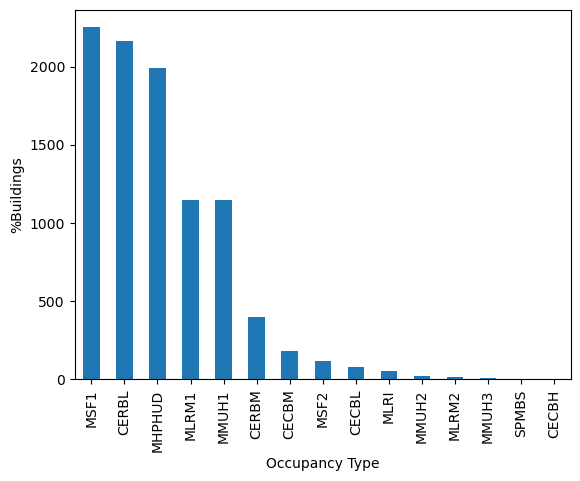

In [6]:
# Structural Archetypes
structuretype_counts=blg.type.value_counts()
structuretype_counts.plot(kind='bar')
plt.xlabel('Occupancy Type')
plt.ylabel('%Buildings')
# plt.show()
plt.savefig('Structural_Archetypes.png', dpi=300)

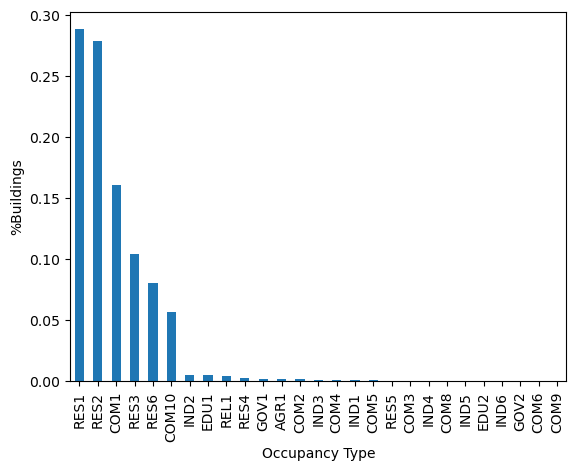

In [7]:
# Building Occupancy Classes
occupancy_counts = blg.Occupancy.value_counts(normalize=True)
occupancy_counts.plot(kind='bar')
plt.xlabel('Occupancy Type')
plt.ylabel('%Buildings')
# plt.show()
plt.savefig('Occupancy_Type.png', dpi=300)

In [8]:
blg.head(2)

id          x          y  Floor Occupancy   type      area  vid
0   1  91.836460  22.326843    1.0      COM1  CERBL   14.5510  521
1   2  91.837403  22.326908    1.0      COM1  MLRM1  507.6702  521

#### Scenario Hurricane - Wind Speed Simulation

In [9]:
# Running wind hazard module to estimate Cyclone track characteristics and Wind Speeds
# df_bdg_wind: database return with wind speed, VG: gust wind velocity
cyclone_parameters = CycloneParameters(track_df)
df_track = cyclone_parameters.estimate_parameters()
df_bdg_wind, VG = cyclone_parameters.calculate_wind_speeds(df_track, blg)

In [10]:
df_bdg_wind.head(2)

id          x          y  Floor Occupancy   type      area  vid  ind  \
0   1  91.836460  22.326843    1.0      COM1  CERBL   14.5510  521    1   
1   2  91.837403  22.326908    1.0      COM1  MLRM1  507.6702  521    2   

          mph  
0  155.249975  
1  155.246906

In [11]:
df_bdg_wind.shape

(9578, 10)

In [12]:
df_bdg_wind.drop(['ind'], axis=1, inplace=True)

#### Plotting Peak Gust Wind Speed - All Structuras

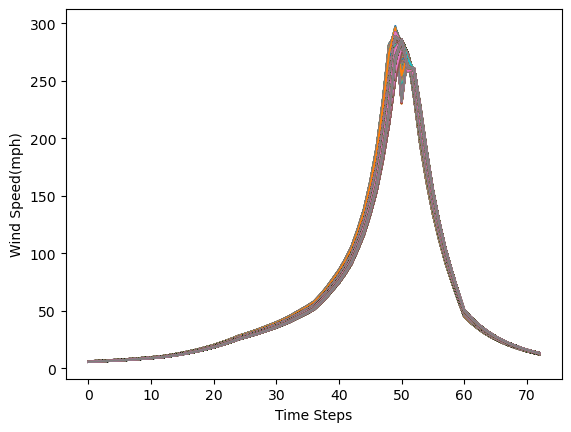

In [13]:
# Plot Peak Gust Wind Speed
VG.plot.line(legend=None)
plt.xlabel('Time Steps')
plt.ylabel('Wind Speed(mph)')
plt.savefig('Cyclone_Hazard_Buildings.png', dpi=300)

### 2. Vulnerability Analysis - Damage States Simulation

In [14]:
# Assign random seed to reproduce random numbers
seed=1234
np.random.seed(seed)

In [15]:
# Building invetory dataframe
df_bdg_wind.head(2)

id          x          y  Floor Occupancy   type      area  vid         mph
0   1  91.836460  22.326843    1.0      COM1  CERBL   14.5510  521  155.249975
1   2  91.837403  22.326908    1.0      COM1  MLRM1  507.6702  521  155.246906

In [16]:
building_data = df_bdg_wind

In [17]:
# Defining Damage States - four damage states as per HAZUS (FEMA)
DStates=['Slight','Moderate','Extensive', 'Complete']

In [18]:
# Running Vulnerability Analysis based on Fragility Curves to assign Damage States to Structures
fra= FragilityAnalysis(fragility_curves)
Pr = fra.estimate_damage_state(building_data)
damage_state = fra.sample_damage_state(Pr, DStates,seed)

In [19]:
# Creating DS Dataframe
ids, statuses = damage_state
df_ds = pd.DataFrame({'id': ids, 'status': statuses})

In [20]:
# Mapping Damage States [DStates] to Structures
DamageStateMap = {None: 0, 'Slight': 1, 'Moderate': 2, 'Extensive': 3, 'Complete': 4}
df_ds['dmg'] = df_ds['status'].map(DamageStateMap)

In [21]:
df_ds.head(2)

id     status  dmg
0   1  Extensive    3
1   2   Moderate    2

In [22]:
# Adding columns to estimate damage State Probabilities (LS: Limit State, DS: Damage State)
DS_Prob=Pr
DS_Prob['LS1'] = DS_Prob['Slight']
DS_Prob['LS2'] = DS_Prob['Moderate']
DS_Prob['LS3'] = DS_Prob['Extensive']
DS_Prob['LS4'] = DS_Prob['Complete']
DS_Prob['DS0'] = 1 - DS_Prob['Slight']
DS_Prob['DS1'] = DS_Prob['Slight'] - DS_Prob['Moderate']
DS_Prob['DS2'] = DS_Prob['Moderate'] - DS_Prob['Extensive']
DS_Prob['DS3'] = DS_Prob['Extensive'] - DS_Prob['Complete']
DS_Prob['DS4'] = DS_Prob['Complete']

In [23]:
DS_Prob.head(2)

Slight  Moderate  Extensive      Complete  id          x          y  \
0  0.791333  0.574869   0.232671  1.590785e-08   1  91.836460  22.326843   
1  0.825029  0.699337   0.409808  1.607358e-01   2  91.837403  22.326908   

          mph   type Occupancy       LS1       LS2       LS3           LS4  \
0  155.249975  CERBL      COM1  0.791333  0.574869  0.232671  1.590785e-08   
1  155.246906  MLRM1      COM1  0.825029  0.699337  0.409808  1.607358e-01   

        DS0       DS1       DS2       DS3           DS4  
0  0.208667  0.216464  0.342197  0.232671  1.590785e-08  
1  0.174971  0.125692  0.289529  0.249072  1.607358e-01

In [24]:
# Merge Assigned Damage States (dmg) and DS probabilities to structure inventory
result_blg_damage=pd.merge(DS_Prob, df_ds, on='id')

In [25]:
# result of blg damage
result_blg_damage.head(2)

Slight  Moderate  Extensive      Complete  id          x          y  \
0  0.791333  0.574869   0.232671  1.590785e-08   1  91.836460  22.326843   
1  0.825029  0.699337   0.409808  1.607358e-01   2  91.837403  22.326908   

          mph   type Occupancy  ...       LS2       LS3           LS4  \
0  155.249975  CERBL      COM1  ...  0.574869  0.232671  1.590785e-08   
1  155.246906  MLRM1      COM1  ...  0.699337  0.409808  1.607358e-01   

        DS0       DS1       DS2       DS3           DS4     status dmg  
0  0.208667  0.216464  0.342197  0.232671  1.590785e-08  Extensive   3  
1  0.174971  0.125692  0.289529  0.249072  1.607358e-01   Moderate   2  

[2 rows x 21 columns]

#### Plotting Wind Speed and Damage States

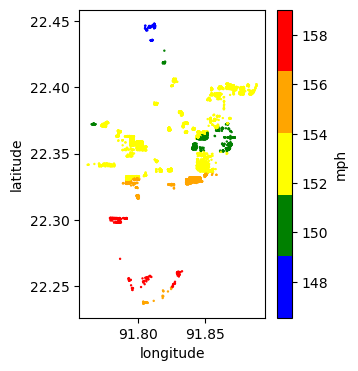

In [26]:
# plot wind speed
plot_scatter(result_blg_damage, 'x', 'y', 'mph', colorbar_label='mph', save_path='wind_speed.png')

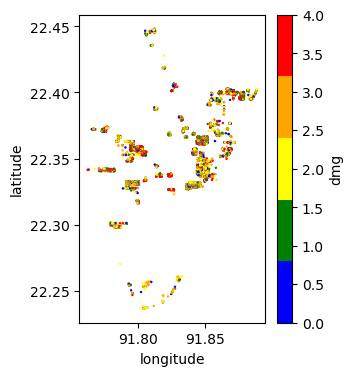

In [27]:
# plot damage states
plot_scatter(result_blg_damage, 'x', 'y', 'dmg', colorbar_label='dmg', save_path='blg_dmg_states_unrehab.png')

### 3. Failure Probability Estimation - Monte Carlo Simulation

In [28]:
# Inventory results from Hazard and Vulnerability Analyses
result_blg_damage.head(2)

Slight  Moderate  Extensive      Complete  id          x          y  \
0  0.791333  0.574869   0.232671  1.590785e-08   1  91.836460  22.326843   
1  0.825029  0.699337   0.409808  1.607358e-01   2  91.837403  22.326908   

          mph   type Occupancy  ...       LS2       LS3           LS4  \
0  155.249975  CERBL      COM1  ...  0.574869  0.232671  1.590785e-08   
1  155.246906  MLRM1      COM1  ...  0.699337  0.409808  1.607358e-01   

        DS0       DS1       DS2       DS3           DS4     status dmg  
0  0.208667  0.216464  0.342197  0.232671  1.590785e-08  Extensive   3  
1  0.174971  0.125692  0.289529  0.249072  1.607358e-01   Moderate   2  

[2 rows x 21 columns]

In [29]:
# Defining Damage Intervals and Failure State (i.e., DS3 and DS4 will considered failure)
bldg_result=result_blg_damage 
damage_interval_keys=['DS0', 'DS1', 'DS2', 'DS3', 'DS4']
failure_state_keys=['DS3', 'DS4']
num_samples=10

In [30]:
# Estimating Failure Probabilites
calculator = DamageProbabilityCalculator(failure_state_keys)
dt, ki = calculator.sample_damage_interval(bldg_result, damage_interval_keys, num_samples, seed)

In [31]:
# Creating pf Dataframe
df_bldg = pd.DataFrame({'id': ki,'pf': dt})

In [32]:
df_bldg.head(2)

id   pf
0   1  0.5
1   2  0.6

In [33]:
# Merge failure probability to structural inventory data
result_bldg_pf=pd.merge(result_blg_damage, df_bldg, on='id')

In [34]:
result_bldg_pf.head(2)

Slight  Moderate  Extensive      Complete  id          x          y  \
0  0.791333  0.574869   0.232671  1.590785e-08   1  91.836460  22.326843   
1  0.825029  0.699337   0.409808  1.607358e-01   2  91.837403  22.326908   

          mph   type Occupancy  ...       LS3           LS4       DS0  \
0  155.249975  CERBL      COM1  ...  0.232671  1.590785e-08  0.208667   
1  155.246906  MLRM1      COM1  ...  0.409808  1.607358e-01  0.174971   

        DS1       DS2       DS3           DS4     status  dmg   pf  
0  0.216464  0.342197  0.232671  1.590785e-08  Extensive    3  0.5  
1  0.125692  0.289529  0.249072  1.607358e-01   Moderate    2  0.6  

[2 rows x 22 columns]

#### PlottingProbability of Failure

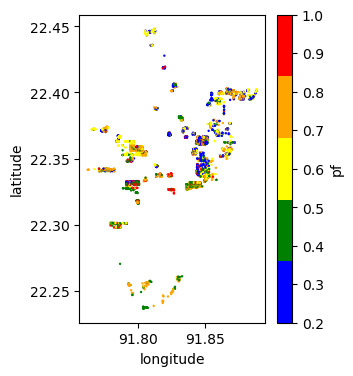

In [35]:
# plot damage failure probability
plot_scatter(result_bldg_pf, 'x', 'y', 'pf', colorbar_label='pf', save_path='pf.png')

#### Fitting Failure Probabilities to Lognormal Distribution

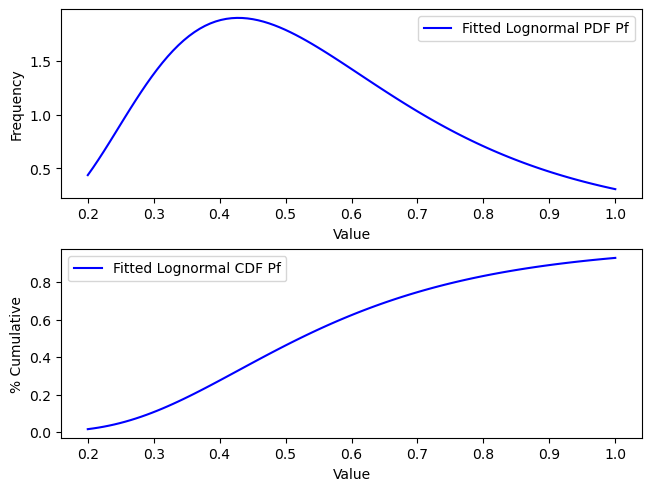

In [36]:
# Plot fitted lognormal PDF & CDF of prob. of failure
dff=plot_lognormal_distribution(result_bldg_pf)
plt.savefig('lognorm.png', dpi=300)
plt.show()

### 4. Loss Estimation - Damage Repair Cost

In [37]:
# Calculate replacement cost of individual building, UC: Unit Cost and RCost: Replacement Cost
df_cost = map_cost(blg)

In [38]:
df_cost.head(2)

id          x          y  Floor Occupancy   type      area  vid     UC  \
0   1  91.836460  22.326843    1.0      COM1  CERBL   14.5510  521  569.0   
1   2  91.837403  22.326908    1.0      COM1  MLRM1  507.6702  521  780.0   

        RCost  
0    8279.519  
1  395982.756

In [39]:
# Merge cost and damage outputs
df_cost_dmg=pd.merge(df_cost, df_ds, on='id')

In [40]:
# Generate Damage Ratio of each building
Loss = damage_ratio(df_cost_dmg)

In [41]:
# Estimate Physical Damage Repair Cost ($) for each building
Loss['PhyLoss']=Loss['RCost']*Loss['DRatio']

In [42]:
# Project Loss due to Physical Damage in $USD
TotalLoss=Loss.PhyLoss.sum()
TotalPhyLoss=Loss.PhyLoss.sum()
print(f"{TotalLoss / 1000000:.1f} Million USD")

6181.1 Million USD


### 5. Recovery Simulations

In [43]:
# Building inventory with DS
building_dmg= pd.merge(blg, df_ds, on='id')
result_blg_dmg=building_dmg

In [44]:
# Simulating Recovery Time of Buildings
recovery_time = rep(result_blg_dmg)
result_blg_dmg['RT_bdg'] = list(recovery_time)

In [45]:
result_blg_dmg.head(2)

id          x          y  Floor Occupancy   type      area  vid     UC  \
0   1  91.836460  22.326843    1.0      COM1  CERBL   14.5510  521  569.0   
1   2  91.837403  22.326908    1.0      COM1  MLRM1  507.6702  521  780.0   

        RCost     status  dmg      RT_bdg  
0    8279.519  Extensive    3  358.054675  
1  395982.756   Moderate    2  101.607680

In [46]:
bb = []
tt = list(range(0, 1000, 5))
for T in tt:
    bb.append(result_blg_dmg[result_blg_dmg.RT_bdg < T].shape[0])

In [47]:
bb=pd.Series(bb)*100/result_blg_dmg.shape[0]

In [48]:
x = list(tt)
y1 = list(bb)
rec_bldg=pd.DataFrame({'T': x,'Rec': y1})

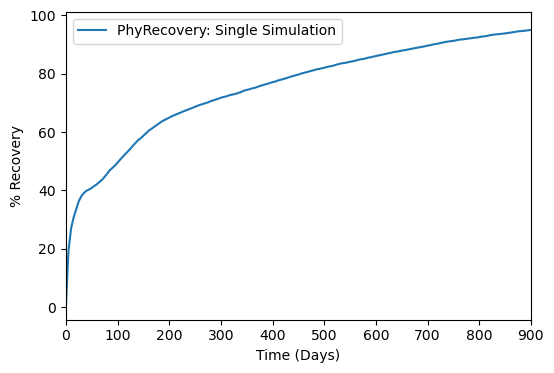

In [49]:
# Plot recovery curve - single simulation
plt.figure(figsize=(6, 4))
plt.plot(x, y1, label='PhyRecovery: Single Simulation')
plt.xlabel("Time (Days)")
plt.ylabel("% Recovery")
plt.legend()
plt.xlim(0, 900)
plt.savefig('Recovery_Single.png', dpi=300)
plt.show()

In [50]:
# Recovery Analysis - Multiple Recovery Scenarios using Monte Carlo Simulation
x, all_simulations, mean, minimum, maximum = recovery_monte_carlo_simulation(result_blg_dmg, num_simulations=10)

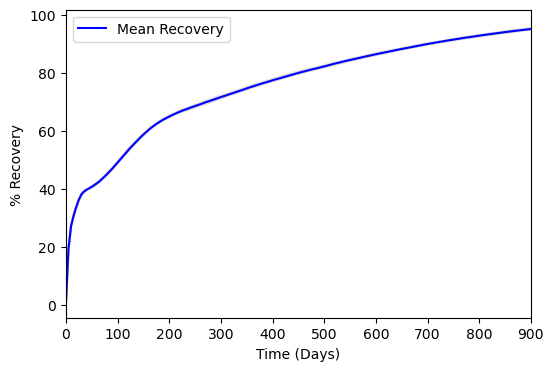

In [51]:
# Plot recovery curve - Mean Recovery
plt.figure(figsize=(6, 4))
for simulation in all_simulations:
    plt.plot(x, simulation, color='lightgray', alpha=.5)
plt.plot(x, mean, color='blue', label='Mean Recovery')
plt.xlabel("Time (Days)")
plt.ylabel("% Recovery")
plt.legend()
plt.xlim(0, 900)
plt.savefig('Recovery_MCS.png', dpi=300)
plt.show()

### 6. Rahab Simulation

#### Simulating 50% Rehab

In [52]:
# Building damage outcomes and probability of failures
output_building=result_bldg_pf

In [53]:
# Repairing buildings that has pf>0.7
output_building.pf[output_building.pf>0.7].shape[0]/output_building.pf.shape[0]

0.10158697013990395

In [54]:
# Updating Building Type for buildings prioritized for repair, 'type_R', _R represets rehab
df=output_building
df['ntype'] = df.apply(lambda row: f"{row['type']}{'_R'}" if row['pf'] >0.4 else row['type'], axis=1)

In [55]:
df=df.drop(columns=['type'])

In [56]:
df.rename(columns={'ntype': 'type'}, inplace=True)

In [57]:
# rehab factor and updating fragility curves accordingly
rehab_factor = 1.3
fragility_curves_rehab = rehab_fragility_curves(rehab_factor)

In [58]:
DStates=['Slight','Moderate','Extensive', 'Complete']
fra= FragilityAnalysis(fragility_curves_rehab)
Pr_rehab = fra.estimate_damage_state(df)
damage_state_rehab = fra.sample_damage_state(Pr_rehab, DStates,seed)
ids, statuses = damage_state_rehab
df_ds = pd.DataFrame({'id': ids, 'status': statuses})
DamageStateMap = {None: 0, 'Slight': 1, 'Moderate': 2, 'Extensive': 3, 'Complete': 4}
df_ds['dmg'] = df_ds['status'].map(DamageStateMap)
DS_Prob=Pr_rehab
DS_Prob['LS1'] = DS_Prob['Slight']
DS_Prob['LS2'] = DS_Prob['Moderate']
DS_Prob['LS3'] = DS_Prob['Extensive']
DS_Prob['LS4'] = DS_Prob['Complete']
DS_Prob['DS0'] = 1 - DS_Prob['Slight']
DS_Prob['DS1'] = DS_Prob['Slight'] - DS_Prob['Moderate']
DS_Prob['DS2'] = DS_Prob['Moderate'] - DS_Prob['Extensive']
DS_Prob['DS3'] = DS_Prob['Extensive'] - DS_Prob['Complete']
DS_Prob['DS4'] = DS_Prob['Complete']
blg_dmg_rehab=pd.merge(DS_Prob, df_ds, on='id')
## Cost Info
new_blg_dmg_rehab = blg_dmg_rehab[['id', 'dmg']]
blg_dmg_rehab=pd.merge(df_cost, new_blg_dmg_rehab, on='id')

In [59]:
# new damage states of buildings after rehab
blg_dmg_rehab.head(2)

id          x          y  Floor Occupancy   type      area  vid     UC  \
0   1  91.836460  22.326843    1.0      COM1  CERBL   14.5510  521  569.0   
1   2  91.837403  22.326908    1.0      COM1  MLRM1  507.6702  521  780.0   

        RCost  dmg  
0    8279.519    1  
1  395982.756    0

In [60]:
# estimating physical replacement cost after applying rehab
result_p = damage_ratio(blg_dmg_rehab)
result_p['PhyLoss']=result_p['RCost']*result_p['DRatio']
TotalLoss=result_p.PhyLoss.sum()
print(f"{TotalLoss / 1000000:.1f} Million USD")

1434.7 Million USD


### 7. Plotting Outputs Interactively - Damage States

In [61]:
# Plot Damage State
node=blg_dmg_rehab.loc[0:,'x': 'y']
node_dmg=blg_dmg_rehab.loc[0:,'dmg']

In [62]:
m=plot_interactive_map(node, node_dmg, node_size=3, node_cmap_bins='cut', node_cmap=None, link_cmap=None)

In [63]:
outfp = "base_map.html"
m.save(outfp)

In [64]:
m

### 8. Social Impact Analysis

In [65]:
# Building Data with damage
building_dmg.head(2)

id          x          y  Floor Occupancy   type      area  vid     UC  \
0   1  91.836460  22.326843    1.0      COM1  CERBL   14.5510  521  569.0   
1   2  91.837403  22.326908    1.0      COM1  MLRM1  507.6702  521  780.0   

        RCost     status  dmg      RT_bdg  
0    8279.519  Extensive    3  250.057142  
1  395982.756   Moderate    2   98.157281

In [66]:
df=building_dmg
df['unit'] = categorize_areas(df)
df['hh_unit'] = df["Floor"] * df["unit"]

In [67]:
# Assume buildings will be non-operable if DS>2 (i.e., extensive or complete)
df=df[df.dmg>2]

In [68]:
# Dislocated households
residential_df = df[df['Occupancy'].isin(['RES1', 'RES2', 'RES3', 'RES4', 'RES5', 'RES6'])]
educational_df = df[df['Occupancy'].isin(['EDU1', 'EDU2'])]
government_df = df[df['Occupancy'].isin(['GOV1', 'GOV2'])]
industrial_df = df[df['Occupancy'].isin(['IND1', 'IND2', 'IND3', 'IND4', 'IND5', 'IND6'])]

In [69]:
print('Total residential buildings dislocated:', residential_df.shape[0])
print('Total households dislocated:', residential_df.hh_unit.sum())
print('Total education buildings damaged:', educational_df.shape[0])
print('Total government buildings damaged:', government_df.shape[0])
print('Total industrial buildings damaged:', industrial_df.shape[0])

Total residential buildings dislocated: 3502
Total households dislocated: 7731.0
Total education buildings damaged: 41
Total government buildings damaged: 17
Total industrial buildings damaged: 75


### 9. EPN Damage Analysis 

In [70]:
# Electrical Poles Inventory
epn_data = pd.read_csv('pole.csv')

In [71]:
epn_data.head(2)

id          x          y          LAYER type
0   1  91.858552  22.385433  Electric_Pole   PW
1   2  91.859630  22.386257  Electric_Pole   PW

In [72]:
# Running wind hazard module to estimate Cyclone track characteristics and Wind Speeds
# df_epn_wind: database return with wind speed, VG: gust wind velocity
cyclone_parameters = CycloneParameters(track_df)
df_track = cyclone_parameters.estimate_parameters()
df_epn_wind, VG = cyclone_parameters.calculate_wind_speeds(df_track, epn_data)

In [73]:
df_epn_wind.drop(['ind'], axis=1, inplace=True)

In [74]:
# Assign random seed to reproduce random numbers
seed=1234
np.random.seed(seed)

In [75]:
epn_data = df_epn_wind

In [76]:
# Defining Damage States
DStates=['Fail']

In [77]:
# Running Vulnerability Analysis based on Fragility Curves to assign Damage States to Structures
fra= FragilityAnalysis(fragility_curves_epn)
Pr = fra.estimate_epn_damage_state(epn_data)
epn_damage_state = fra.sample_damage_state(Pr, DStates,seed)

In [78]:
ids, statuses = epn_damage_state
df_epn_ds = pd.DataFrame({'id': ids, 'status': statuses})

In [79]:
# Map Damage States [DStates] to Structures
DamageStateMap = {None: 0, 'Fail': 1}
df_epn_ds['dmg'] = df_epn_ds['status'].map(DamageStateMap)

In [80]:
# Add columns to estimate damage State Probabilities (LS: Limit State, DS: Damage State)
DS_Prob=Pr
DS_Prob['LS1'] = DS_Prob['Fail']
DS_Prob['DS0'] = 1 - DS_Prob['Fail']
DS_Prob['DS1'] = DS_Prob['Fail']

In [81]:
# Merge Assigned Damage States (dmg) and DS probabilities to structure inventory
result_epn_damage= pd.merge(DS_Prob, df_epn_ds, on='id')

In [82]:
result_epn_damage.head(2)

Fail  id          x          y         mph type       LS1       DS0  \
0  0.905096   1  91.858552  22.385433  152.573308   PW  0.905096  0.094904   
1  0.905195   2  91.859630  22.386257  152.584165   PW  0.905195  0.094805   

        DS1 status  dmg  
0  0.905096   Fail    1  
1  0.905195   Fail    1

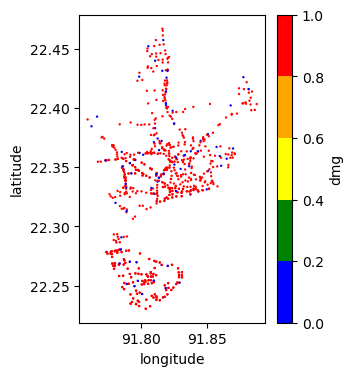

In [83]:
# plot damage state maps
plot_scatter(result_epn_damage, 'x', 'y', 'dmg', colorbar_label='dmg', save_path='dsm_epn.png')

In [84]:
# Plot Damage
node=result_epn_damage.loc[0:,'x': 'y']
node_dmg=result_epn_damage.loc[0:,'dmg']
m_epn=plot_interactive_map(node, node_dmg, node_size=3, node_cmap_bins='cut', node_cmap=None, link_cmap=None)

In [85]:
outfp = "base_map_epn.html"
m_epn.save(outfp)

In [86]:
m_epn

### 10. Functionality Analysis - Connecting Building & EPN Performance

In [87]:
# Building Inventoy is mapped to corresponding dependent EPN pole through voronoi polygon
# Voronoi polygon is a geospatial analysis to determine service area for each electrical outlet (i.e. poles)

Here are steps for conducting Voronoi analysis in QGIS (this can be done using other tools):

1. **Prepare Data:** load EPN layer and ensure it's in a projected coordinate system.
2. **Open Processing Toolbox:** go to `Processing` > `Toolbox`.
3. **Generate Voronoi Polygons:** search for `Voronoi polygons` in the toolbox, select EPN layer as input, specify output settings (study area boundary), and run the tool.
4. **Connect Building to Voronoi Layer:** intersect building layer to voronoi layer to assign dependent voronoi service area and/or dependent electrical pole. 'vid' field in the building layer is obtained through this process and vid represents epn id, as well as voronoi id corresponds to a building

In [88]:
# building inventory with voronoi and damage info
building_dmg.head()

id          x          y  Floor Occupancy   type      area  vid     UC  \
0   1  91.836460  22.326843    1.0      COM1  CERBL   14.5510  521  569.0   
1   2  91.837403  22.326908    1.0      COM1  MLRM1  507.6702  521  780.0   
2   3  91.836467  22.326924    2.0      COM1  CERBL    9.0811  521  921.0   
3   4  91.836294  22.327024    1.0      COM1  CERBL   58.4368  521  569.0   
4   5  91.837552  22.326973    1.0      COM1  MLRM1   17.1670  521  780.0   

         RCost     status  dmg      RT_bdg  unit  hh_unit  
0    8279.5190  Extensive    3  250.057142     1      1.0  
1  395982.7560   Moderate    2   98.157281     4      4.0  
2    8363.6931   Moderate    2   96.735375     1      2.0  
3   33250.5392     Slight    1    9.557175     1      1.0  
4   13390.2600     Slight    1    9.591157     1      1.0

In [89]:
# EPN Damage State
result_epn = result_epn_damage[['id', 'dmg']].rename(columns={'dmg': 'dmg_epn','id':'id_epn'})

In [90]:
# Merge building and EPN damage data
blg_epn_results = pd.merge(building_dmg, result_epn, left_on='vid', right_on='id_epn')

In [91]:
blg_epn_results.head(2)

id          x          y  Floor Occupancy   type      area  vid     UC  \
0   1  91.836460  22.326843    1.0      COM1  CERBL   14.5510  521  569.0   
1   2  91.837403  22.326908    1.0      COM1  MLRM1  507.6702  521  780.0   

        RCost     status  dmg      RT_bdg  unit  hh_unit  id_epn  dmg_epn  
0    8279.519  Extensive    3  250.057142     1      1.0     521        0  
1  395982.756   Moderate    2   98.157281     4      4.0     521        0

In [92]:
# Calculate Functionality State: 'FS'
df_func = calculate_fs(blg_epn_results, 'dmg', 'dmg_epn')

In [93]:
# Functionality Results (0: No Functionality, 1: Partially Functional, 2: Fully Functional)
df_func.FS.value_counts()

FS
0    4575
1    4344
2     659
Name: count, dtype: int64